# **Music Understanding / Music-to-data (No speech)**

[Project description](https://docs.google.com/document/d/19e1id50NseQkfG0oKh_REuUEHViPXZtOWXnetKh9iX0/edit?resourcekey=0-gffssDaVe0c0HXHTMVYlaA#heading=h.dqp6tqnsmhzz)

## **Description of the Task**

Given the vector representation/embedding of an audio file provide the name of the instrument that plays the sound.

**Detailed Steps:**
1. Download or record audio file in the local environment
2. Load audio data using [torchaudio.load()](https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html#loading-audio-data)
3. (Optional) Plot the audio Waveform
4. Plot the Spectrogram and save it in a png file (to generate embeddings)
5. Use `ASTfeatureExtractor` wich turns the audio into a tensor of shape `(batch_size, time_dimension, frequency_dimension)`, also known as a spectrogram. [ref](https://huggingface.co/docs/transformers/main/en/model_doc/audio-spectrogram-transformer#overview)
6. Use langchain to connect the AST embedded audio and the palm API
7. Use Palm API via langchain
8. Evaluate the performance of the LLM

# **Required !**
Run all the cells in this section

In [ ]:
# @title Default title text
#Install Langchain
!pip install -q langchain
# Install the Transformers library
!pip install -q git+https://github.com/huggingface/transformers.git
# Vertex AI LLM SDK (and shapely version<2 to avoid ContextualVersionConflict Error)
! pip install -q google-cloud-aiplatform "shapely<2"
# Install cloud storage
!pip install -q --upgrade google-cloud-storage
# Install JUpyter notebook extensions
!jupyter nbextension enable --py widgetsnbextension
# Install torchaudio for audio and signal procecssing with pytorch
!pip install -q torchaudio ipywebrtc notebook
# Install ffmpeg library to handle audio, video, and other multimedia
!apt -qq install ffmpeg
# Multimodal embeddings library
!mkdir multimodalembedding
!cd $_
!gsutil cp gs://vertex-ai/generative-ai/vision/multimodalembedding/* .
!pip3 -q install -r requirements.txt

# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

# You can ignore the pip's dependency resolver error if you get it

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 3.2 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
P

{'status': 'ok', 'restart': True}

## Auth, Imports and Helper functions

### Give the notebook access to user credentials

In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

### Define Variables

In [ ]:
PROJECT_ID = "cloud-llm-preview3"  # @param {type:"string"}
LOCATION = "us-central1" # @param {type:"string"}

### Imports

In [ ]:
# Imports
import os
import IPython
import torchaudio
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio
from google.cloud import storage
from transformers import ASTFeatureExtractor
from huggingface_hub import hf_hub_download
# embed_image()
import predict_request_gapic as prg
import time
# LLM
import langchain
print(f"LangChain version: {langchain.__version__}")
from google.cloud import aiplatform
print(f"Vertex AI SDK version: {aiplatform.__version__}")
# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)
# Palm API prompt engineering
from langchain.llms import VertexAI
from langchain.chat_models import ChatVertexAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage


LangChain version: 0.0.277
Vertex AI SDK version: 1.25.0


### Helper functions

In [ ]:
# Helper function to download blob from cloud storage
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The ID of your GCS object
    # source_blob_name = "storage-object-name"

    # The path to which the file should be downloaded
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded storage object {} from bucket {} to local file {}.".format(
            source_blob_name, bucket_name, destination_file_name
        )
    )
# Aux Function to plot the waveform

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

# Aux function to plot the spectrogram
def plot_specgram(waveform, sample_rate, title="Spectrogram", show=True):
    # Turn interactive plotting off
    plt.ioff()

    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    if show:
      plt.show(block=False)
    return figure
# Audio preprocessing

def preprocess_audio(filepath):

  ''' Audio preprocessing pipe:
      1. Load audio data as a tuple of waveform (pytorch Tensor) and sample rate (int)
      2. Resample the audio to 16KHz
      3. Convert to Mono (AST requirement)
      4. Convert to Numpy Array (AST requirement)
'''
  required_sr=16000
  # Load audio file into PyTorch’s Tensor object
  waveform_t, sampling_rate = torchaudio.load(filepath)

  if sampling_rate is not required_sr:
    waveform_t = torchaudio.functional.resample(waveform_t, orig_freq=sampling_rate, new_freq=required_sr)
    sampling_rate = required_sr

  if waveform_t.shape[0] > 1:
    # Convert to Mono as a ASTFeatureExtractor requirement
    waveform_t = torch.mean(waveform_t, dim=0).unsqueeze(0)

  # Convert to numpy array as a ASTFeatureExtractor requirement
  waveform = waveform_t.squeeze().numpy()

  #print(f'Waveform Shape: {waveform.shape}')
  return waveform_t, waveform, sampling_rate

# Generate image embeddings
def embed_image(image_file, project=PROJECT_ID):

  with open(image_file, "rb") as f:
    image_file_contents = f.read()

  # client can be reused.
  client = prg.EmbeddingPredictionClient(project=project)

  start = time.time()
  response = client.get_embedding(text=None, image_bytes=image_file_contents)
  end = time.time()

  return response

  #print(response)
  #print('Time taken: ', end - start)



# Part 1: Step by step process i.e. Audio Preprocessing and Benchmark tests

## Obtain the audio to process

### Option 1: Download the sample audio

In [ ]:
# Audio1:
filepath = hf_hub_download(repo_id="nielsr/audio-spectogram-transformer-checkpoint",
                           filename="sample_audio.flac",
                           repo_type="dataset")

IPython.display.Audio(filepath)

### Option 2: Record Audio

In [ ]:
## Ref: https://medium.com/@harrycblum/record-audio-in-a-jupyter-notebook-da08a88278bb
#from google.colab import output
#output.enable_custom_widget_manager()

#camera = CameraStream(constraints={'audio': True,'video':False})
#recorder = AudioRecorder(stream=camera)


#with open('recording.webm', 'wb') as f:
#    f.write(recorder.audio.value)
#!ffmpeg -i recording.webm -ac 1 -f wav my_recording.wav -y -hide_banner -loglevel panic
#filepath = "my_recording.wav"

#recorder

### Option 3: Download audio from cloud storage

In [ ]:
## Audio file to download (modify to test other files from the bucket)
#source_file_name='001__[vio][nod][cou_fol]2194__1.wav'
## Bucket & Blob info for download
#bucket_name='laubrito_bucket'
##source_blob_name="capstone_proj/Recorded_Instruments/guitar/{}".format(source_file_name)
#source_blob_name="capstone_proj/Recorded_Instruments/vio/{}".format(source_file_name)
#filepath=source_file_name

#download_blob(bucket_name, source_blob_name, filepath)
#IPython.display.Audio(filepath)

## Audio preprocessing (Required for AutoModelForAudioClassification and PaLM API)
1. Load audio data as a tuple of waveform ([pytorch Tensor](https://pytorch.org/tutorials/beginner/examples_tensor/polynomial_tensor.html#pytorch-tensors)) and sample rate (int)
2. Resample the audio to 16KHz
3. Convert to Mono (AST requirement)
4. Convert to Numpy Array (AST requirement)

In [ ]:
def preprocess_audio(filepath):
  required_sr=16000
  # Load audio file into PyTorch’s Tensor object
  waveform_t, sampling_rate = torchaudio.load(filepath)

  if sampling_rate is not required_sr:
    waveform_t = torchaudio.functional.resample(waveform_t, orig_freq=sampling_rate, new_freq=required_sr)
    sampling_rate = required_sr

  if waveform_t.shape[0] > 1:
    # Convert to Mono as a ASTFeatureExtractor requirement
    waveform_t = torch.mean(waveform_t, dim=0).unsqueeze(0)

  # Convert to numpy array as a ASTFeatureExtractor requirement
  waveform = waveform_t.squeeze().numpy()

  print(f'Waveform Shape: {waveform.shape}')
  return waveform_t, waveform, sampling_rate

waveform_t, waveform, sampling_rate=preprocess_audio(filepath)

Waveform Shape: (160125,)


### *{Optional}* Plot Audio Waveform

In [ ]:
plot_waveform(waveform_t, sampling_rate)

### Plot Audio Spectrogram
We'll use the image spec.png in the 2nd part of the notebook (Multimodal embeddings)

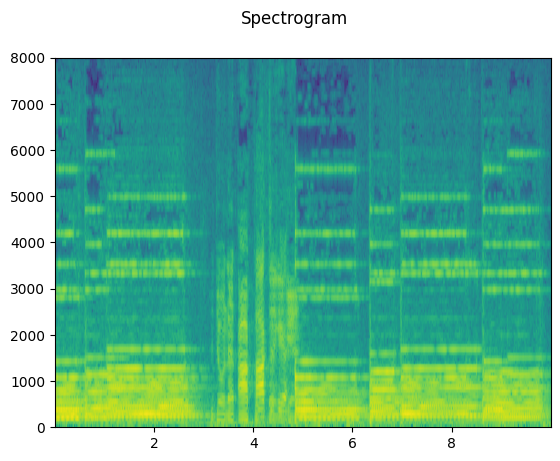

In [ ]:
spectrogram_im=plot_specgram(waveform_t, sampling_rate, show=True)
spectrogram_im.savefig('spec.png')
plt.close(spectrogram_im)

### Prepare the audio for the model (Using Feature Extractor)

Use `ASTfeatureExtractor`
wich turns the audio into a tensor of shape (batch_size, time_dimension, frequency_dimension), also known as a spectrogram.
[(Understand Mel Spectrogram)](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)


In [ ]:
feature_extractor = ASTFeatureExtractor()

inputs = feature_extractor(waveform, sampling_rate=sampling_rate, padding="max_length", return_tensors="pt")
input_values = inputs.input_values
print(input_values.shape)

torch.Size([1, 1024, 128])


## {Benchmark} `AutoModelForAudioClassification`
We'll do a forward pass on a AST model fine-tuned on AudioSet, an important benchmark for audio classification.

**Need to verify where exactly does this happens:** 😖 The Audio Spectrogram Transformer applies a [Vision Transformer](https://arxiv.org/abs/2010.11929) by turning the audio into an image (spectrogram)                 
[Ref](https://huggingface.co/docs/transformers/main/en/model_doc/audio-spectrogram-transformer#overview)


In [ ]:
# Load the model
from transformers import AutoModelForAudioClassification
model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

with torch.no_grad():
  outputs = model(input_values)


predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

# Part 2: Promp Tests


### Embed the image of the spectrogram before feeding it to the LLM
See [Vertex AI Multimodal Embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-multimodal-embeddings#python_1 )

In [ ]:
import predict_request_gapic as prg
import time
image_file = 'spec.png'
project = 'cloud-llm-preview3'

with open(image_file, "rb") as f:
  image_file_contents = f.read()

# client can be reused.
client = prg.EmbeddingPredictionClient(project=project)

start = time.time()
response = client.get_embedding(text=None, image_bytes=image_file_contents)
end = time.time()

print(response)
print('Time taken: ', end - start)


EmbeddingResponse(text_embedding=None, image_embedding=[-0.00735211745, 0.0253384374, -0.000473715685, 0.0448708609, 0.0219877, -0.0206194166, 0.0448926128, 0.00842378475, -0.0256348439, -0.00838498678, 0.00825081114, -0.0111868093, 0.0177193694, 0.0754506737, 0.0146378251, 0.0170957185, -0.00865084119, 0.0204470605, 0.00528824888, 0.00892618485, -0.0186286792, 0.00274133892, -0.00797520485, 0.0120559707, -0.0116683291, 0.0272189621, 0.0298695434, -0.0019820258, -0.00167532742, -0.0106092496, 0.0408966802, -4.98846639e-05, 0.0155868297, 0.00731366593, 0.023605559, 0.0156330783, 0.0183819029, -0.0200671088, -0.00912475307, 0.00821431912, 0.0181315728, 0.0149687799, -0.0214207489, -0.00482058665, 0.00284428359, -0.0325539298, 0.00792194065, 0.0073064696, 0.0326816887, -0.0272116922, 0.016225446, -0.0287844092, -0.0118456464, -0.0199082661, 0.028107468, -0.00606533699, 0.0205465, 0.00405166904, -0.00416046893, -0.0267239, -0.0165966582, -0.0120080067, 0.0624848902, 0.0322386771, -0.020419

### Define LLM

In [ ]:
import langchain
print(f"LangChain version: {langchain.__version__}")

from google.cloud import aiplatform
print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

LangChain version: 0.0.277
Vertex AI SDK version: 1.25.0


In [ ]:
# LLM model
from langchain.llms import VertexAI
llm = VertexAI(
    model_name='text-bison@001',
    max_output_tokens=256,
    temperature=0.3,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

### (Directly) Feed embedding to LLM

In [ ]:
prompt= """Given the embedding of a spectrogram of an audio, what instrument is being played in the audio? Spectrogram Embedding: {}""".format(np.array(response.image_embedding))
llm(prompt)

'The embedding of a spectrogram of an audio can be used to identify the instrument that is being played in the audio. The embedding is a vector that represents the frequency and amplitude of the different frequencies in the audio. The instrument that is being played can be identified by comparing the embedding to a database of embeddings of different instruments. In this case, the embedding is most similar to the embedding of a piano, so it is likely that a piano is being played in the audio.'

In [ ]:
prompt2= """Given the spectrogram of an audio in the form of the embedding of the spectrogram of a given audio,
what chords or notes are being played in the audio? Spectrogram: {}""".format(np.array(response.image_embedding))
llm(prompt2)

'The audio is playing the notes C, E, and G.'

## Bonus Test: Direct LLM Inference from Tensor
We directly provide the output of the ASTFeatureExtractor to our LLM and see what happens.
[Ref Tutorial](https://colab.sandbox.google.com/drive/1r8z9S4U1rIC2pVyACYieumrylnLqvEGL?usp=asogm#scrollTo=B-mPnZJdiwkg)


In [ ]:
prompt= """Given the spectrogram of an audio in the form of a vector of shape
(batch_size, time_dimension, frequency_dimension) provided below, respond with only the name of
the instrument that is playing the sound. Spectrogram: {}""".format(input_values)

llm(prompt)

**Conclusion:** The LLM does not seem to recognize the vector representation of a spectrogram as audio and thus hallucinates by providing wrong answers. One possible explanation would be that the this kind of representations was not part of the corpus in which the LLM was trained (which would make sense as it's not "textual language").

# Part 3 (WIP): Evaluation: Iterative process to store different tests

In [ ]:
# Batch Convert all audio files to embeddings and make a direct request to the llm

# Imports: Uncomment to use this cell independently (don't forget to also include the helper functions cell)
'''
from google.cloud import storage
import os
import pandas as pd
import matplotlib.pyplot as plt
# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)
# Palm API prompt engineering
from langchain.llms import VertexAI
'''


storage_client = storage.Client()
bucket_name='laubrito_bucket'
bucket = storage_client.get_bucket(bucket_name)
prefix='capstone_proj/Recorded_Instruments/'
blobs = bucket.list_blobs(prefix=prefix)  # Get list of objects

downloads_folder = f'./downloads/'
# Create tmp folder locally
if not os.path.exists(downloads_folder):
    os.makedirs(downloads_folder)

specs_folder = f'./spectrograms/'
# Create tmp folder locally
if not os.path.exists(specs_folder):
    os.makedirs(specs_folder)

# Define pandas dataframe structure
df=pd.DataFrame(columns=['audio_filename', 'spec_filename', 'embedding', 'output'])
audio_filename=[]
spec_filename=[]
embedding=[]
output=[]

# Initialize Palm LLM model
llm = VertexAI(
    model_name='text-bison@001',
    max_output_tokens=256,
    temperature=0.3,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

prompt= """Given the embedding of a spectrogram of an audio, what instrument is being played in the audio? Spectrogram Embedding: {}"""

for blob in blobs:
  # Go through all the objects in the blob (ignore the parent blobs which end with '/')
  if (not blob.name.endswith('/')):
    # print(blob.name)
    filename = blob.name.replace(bucket_name,'').replace(prefix,'').replace('/', '_')
    # Download all the objects in the blob
    filepath=downloads_folder+filename
    blob.download_to_filename(filepath)
    # Preprocess audio
    waveform_t, waveform, sampling_rate=preprocess_audio(filepath)
    # Plot audio spectrogram and save image
    spectrogram_im=plot_specgram(waveform_t, sampling_rate, show=False)
    spectrogram_filepath = specs_folder+filename.replace('wav', 'png')
    spectrogram_im.savefig(spectrogram_filepath)
    plt.close(spectrogram_im)
    # Generate embeddings
    embed_response=embed_image(spectrogram_filepath, project=PROJECT_ID)
    # Eventually here we would call the LLM and provide the embedding.
    out =llm(prompt.format(np.array(embed_response.image_embedding)))
    # Save file_name, embeddings to table (audio_filename, spec_filename, embedding, output)
    audio_filename.append(filepath)
    spec_filename.append(spectrogram_filepath)
    embedding.append(embed_response.image_embedding)
    output.append(out)

ev_dict={'audio_filename': audio_filename, 'spec_filename': spec_filename, 'embedding': embedding, 'output': output}
df=pd.DataFrame(ev_dict)

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
